# Computer Vision

Deep Learning has powered Computer Vision for more than a decade now and has enabled us to do tasks that were previously impossible. Before we dig into it, I want to quickly talk about what Computer Vision is and some of areas that exist in the field. 

### Biological Vision
Humans, and most animals, have the ability to understand our environment through our vision. Biologically, our eyes have photoreceptors (rods and cones) that are tasked with taking in light and converting them to electrical signals. These signals are then passed to our brain and high level features are parsed. Lets highlight some things you can do with your eyes!

- **Recognition**: We can look at something and tell you what it is or even desribe in detail
- **Location**: We can understand where the location of an object is with respect to ourselves
- **Depth Perception**: We can guess the relative distance to an object

If we want to build a self-driving car we need to be able to replicate atleast this much with technology! So lets talk about how cameras work then and what ideas are similar. 

### Machine Vision
Cameras typrically house a lens and a sensor. The purpose of the lens is to focus an area of light and project it on the sensor. The sensor contains light sensitive elements that can take this light and convert it to an electrical signals for storage. One of the typical processes is to numerically encode the pixel values we need to be able to represent it in a way computer understand, so we quantize the signal and give every pixel value an intensity from [0-255] for the typical 8bit image. 

### Limitations of a Dense Linear Neural Network
When we trained the MNIST model in the [Intro to PyTorch](https://github.com/priyammaz/HAL-DL-From-Scratch/tree/main/Intro%20to%20PyTorch) section, notice somethign specific about this model itself:

```
class FCNet(nn.Module): # Inherit in nn.Module Class
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 64) # input flattened 28*28 into 64 node layer
        self.fc2 = nn.Linear(64,64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 10) 
        
    def forward(self, x):
        """
        Activation Function: ReLU
        """
        x = x.view(-1, 28*28)    ### THE CULPRIT!!!
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
```

Remember that the MNIST images are small pictures of handwritted digits in the shape 28 pixels x 28 pixels. Before we even passed this data to the model, we did the follwing:

```
x = x.view(-1, 28*28) 
```

This line will take an image and flatten it like this:

```
[1 Channel x 28 Pixels x 28 Pixles] -> [1 Channel x 784 Pixels]
```

But we had to do this? Our linear layer is expecting a single dimension vector of values for every sample, not a matrix? But if we do this, we inherently cause a different issue.


![image](https://testerstories.com/files/ai_and_ml/ml-mnist-2d-to-1d.png)

[credit](https://testerstories.com/2018/09/demystifying-machine-learning-part-5/)

Notice that when we have an image as a 2d matrix, it visually makes sense to us and indicates that this image is 1. If we flatten it to the 1D vector, we essentially just a list of values with intensities, but it is not obviously clear what image it is representing. Therefore we have lost all the **Spatial Features** that define the relationship and our model has no opportunity to learn how a pixel is related to all of its neighbors.


## Convolutions to the rescue!

Convolutions attempt to solve this problem by creating something known as a filter (a matrix of weights) and iteratively sliding it across the image. At every iteration, it performs some local computation and uses that to update the weights of the filter matrix. This sounds like a lot so lets visualize it!

## How Convolutions Slide 
![image](https://miro.medium.com/max/790/1*1okwhewf5KCtIPaFib4XaA.gif)

[credit](https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1)


In this image, the Blue matrix below is our original image and the green matrix above that it is mapping to is the output of the convolution calculation. In this case, the filter is the 3x3 matrix that is sliding along the blue image. The computation being done is not much different from a weighted average. Essentially our filter has some weights in each square (if it is a 3x3 matrix it has 9 weights in total). We multiply each of these weights with the value it is overlapping on the blue image and then add all of them together. This summed value will then be the new value projected to the green matrix above as our output! The border you see around the blue image is known as padding and it allows the convolution mechanic to go over the edge a bit.

**Note**: This is just for extra credit but notice the setup here. You have a filter that is a matrix of values, and you are multiplying it with an input set of values. This sounds kind of like a Linear layer right? Exactly! A convolution isn't all that different from a linear layer, its just that rather than flattening an entire image and passing through a single linear layer, we grab small parts of an image and iteratively pass it through the linear layer so we can focus on more local features!

## Parameters for Convolutions
Luckily for us, PyTorch has a convolution function built for us but there are a few of them depending on the dimension we want. Conv1d would be for a timeseries type of problem that we will explore later. Conv2d is what we need as our images are all 2D (X and Y dimension). There is also higher order ones for data that has more dimensions. MRI Images for example have X, Y and Z dimensions as the brain is a 3D structure, so you would have to use a 3d convolution for that.

```
torch.nn.Conv2d(in_channels,  # Number of Input Channels (RGB images have 3 Input Channels, Grayscale has just 1)
                out_channels, # Number of channels we want to expand out to 
                kernel_size,  # The size of the filter we want
                stride=1,     # How much the filter should move in every iteration
                padding=0     # How much border to put around the image
                )
```

## What is a filter? Lets take a look at the Sobel Filter
![image](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3f/Bikesgray.jpg/400px-Bikesgray.jpg) ![image](https://upload.wikimedia.org/wikipedia/commons/thumb/1/17/Bikesgraysobel.jpg/400px-Bikesgraysobel.jpg)

Convolution filters are not a new concept and have existed for decades. The sobel filter for example can perform tasks like edge detection by performing the following:


$$G_x = \begin{bmatrix}1 & 0 & -1 \\ 2 & 0 & -2 \\ 1 & 0 & -1\end{bmatrix} \ast Image$$


$$G_y = \begin{bmatrix}1 & 2 & 1 \\ 0 & 0 & 0 \\ -1 & -2 & -1\end{bmatrix} \ast Image$$

Where $\ast$ is the Convolution operator visualized by the convolution above! If we did the convolutions and multiplied our images by these matricies we could detect horizontal and vertical lines. What a convolutional Neural Network does is, instead of having some predefined filter like the sobel filter, why dont we let the model learn the best filter for that specific task!

## The Typical CNN Structure 
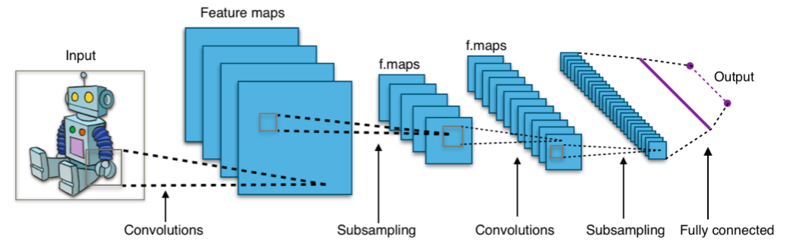

This is the typical way we structure Convolutional Neural Networks. The key features to note here is, as we we progress through the model, the size of the outputs become smaller and smaller, but we increase significantly the number of channels. We also see here something called subsampling between convolutions, or known as Pooling. We will discuss that in just a bit! Once we get to the end, we simply flatten our features and pass to a Linear layer that will then try to map the image features to our output classes.

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import numpy as np

import warnings
warnings.filterwarnings("ignore")

## PyTorch Convolutions
Lets try using the PyTorch Convolution mechanic and just see what happens on a dummy image. We will create an image with 3 channels and have dimensions 128 pixels x 128 pixels. We will then create a few different convolutions to see what happens!

In [11]:
# Create a Random Image
rand = torch.rand(3, 128, 128) 

### Baseline Convolution ###
conv1 = nn.Conv2d(in_channels=3,
                  out_channels=3,
                  kernel_size=3,
                  stride=1,
                  padding=0)

### Convolution With a Larger Kernel ###
conv2 = nn.Conv2d(in_channels=3,
                  out_channels=3,
                  kernel_size=7,
                  stride=1,
                  padding=0)

### Convolution With a Larger Stride ###
conv3 = nn.Conv2d(in_channels=3,
                  out_channels=3,
                  kernel_size=3,
                  stride=3,
                  padding=0)

### Convolutions with a Larger Padding ###
conv4 = nn.Conv2d(in_channels=3,
                  out_channels=3,
                  kernel_size=3,
                  stride=1,
                  padding=2)

### Convolutions with More Output Channels ###
conv5 = nn.Conv2d(in_channels=3,
                  out_channels=64,
                  kernel_size=3,
                  stride=1,
                  padding=0)


conv1_out = conv1(rand)
conv2_out = conv2(rand)
conv3_out = conv3(rand)
conv4_out = conv4(rand)
conv5_out = conv5(rand)

print("Baseline Output:", conv1_out.shape)
print("Larger Kernel Output:", conv2_out.shape)
print("Larger Stride Output:", conv3_out.shape)
print("Larger Padding Output:", conv4_out.shape)
print("More Ouput Channels Output:", conv5_out.shape)


Baseline Output: torch.Size([3, 126, 126])
Larger Kernel Output: torch.Size([3, 122, 122])
Larger Stride Output: torch.Size([3, 42, 42])
Larger Padding Output: torch.Size([3, 130, 130])
More Ouput Channels Output: torch.Size([64, 126, 126])


Lets note some of the properties we see here. First the default settings from PyTorch (a stride of 1 and padding of 0) keeps the same number of output channels as 3 but we have had some decrease in the image size now from 128 to 127. Lets list out how the other things impact it:

- **Larger Kernel Size:** Further decreases the output image size from 128 to 122
- **Larger Stride:** Significantly decreases the output image size from 128 to 42
- **Larger Padding:** Increases the output image size from 128 to 30
- **More Output Channels:** Keeps the same 126 shape output as our baseline but we now have 64 channels instead of 3

We can actually calculate the size of an image after a convolution is applied to it with a simple formula!

$$\frac{Width - KernelSize + 2*Padding}{Stride} + 1$$

How about we try to stack some convolutions like we have to do in a Neural Network? Now there is one thing to keep in mind here. The first convolution will output however many channels you set it to, so the second convolution has to allow their in_channels to accept that amount!

In [15]:
# Create a Random Image
rand = torch.rand(3, 128, 128) 

conv1 = nn.Conv2d(in_channels=3,
                  out_channels=32, ### 32 Output Channels
                  kernel_size=7,
                  stride=2,
                  padding=1)

conv2 = nn.Conv2d(in_channels=32,
                  out_channels=64, ### 32 Input Channels
                  kernel_size=3,
                  stride=1,
                  padding=0)

output = conv2(conv1(rand))

print("Stacked Convolution Shape:", output.shape)

Stacked Convolution Shape: torch.Size([64, 60, 60])


We were able to stack convolutions together! Notice that we have a lot of channels now and have considerable downsized the images from 128 down to 60 here. But there is a few other things we need to talk about before we make our first Convolutional Neural Network.


## Pooling
Convolutions are expensive computations, so downscaling of our images or outputs of convolutions would greatly help reduce the number of dimensions! To do this we will use Pooling layers. The function identically to Convolutions except there is no parameters to learn. Instead of doing the sum of the product of weights of the filter and pixel values like we saw previously, we can do two other things:

- **Average Pooling:** This is just a simple average of the pixels covered by the filter as our output for that specific location
- **Max Pooling:** Even less computation as we just take the maximum value of the pixels covered by the filter

The inputs are very similar to the Convolution function, but there is no channels anymore. The reason is, we will take the average/max at every iteration for every channel. Therefore we will maintain the same number of channels in our output, but will downsize the overall dimension of the image. Lets take a quick look at the functions!

```
torch.nn.AvgPool2d(kernel_size, stride=None, padding=0)
torch.nn.MaxPool2d(kernel_size, stride=None, padding=0)

```
Another thing to keep in mind! As you can see above the stride is None. This is because, by default, the stride will be the same as the kernel size. This will essentially do pooling with non-overlapping intervals. If your filter size is 3, then you will do an average/max at that [3x3] patch of pixels, and then move over 3 pixels, therefore having no overlap. We can make the stride less than our kernel size to reduce the amount of downsampling we are doing. 


Lets take a look at the pooling function!

In [18]:
# Create a Random Image
rand = torch.rand(3, 128, 128) 

### Average Pool Where Stride == Kernel_Size ###
avgpool = nn.AvgPool2d(kernel_size=3)

### Average Pool Where We Decrease Stride ###
avgpool_2 = nn.AvgPool2d(kernel_size=3, stride=2)


out_1 = avgpool(rand)
out_2 = avgpool_2(rand)

print("Kernel Size == Stride", out_1.shape)
print("Reduced Stride to 2", out_2.shape)

Kernel Size == Stride torch.Size([3, 42, 42])
Reduced Stride to 2 torch.Size([3, 63, 63])


Again, just as we saw before, the pooling with a smaller stride had less downsampling! 

### Adaptive Pooling

There is one other function that is very helpful and this is **Adaptive Pooling**. In regular pooling, we set ahead of time the kernel size and stride. In Adaptive Pooling, we set the output size we want and it will figure out the kernel size and stride for us! 

In [24]:
# Create a Random Image
rand = torch.rand(3, 128, 128) 

adaptiveavgpool_1 = nn.AdaptiveAvgPool2d((64,64)) # Output with size 64 x 64
adaptiveavgpool_2 = nn.AdaptiveAvgPool2d((1,1))   # Output with size 1 x 1 
adaptiveavgpool_3 = nn.AdaptiveAvgPool2d((32,64)) # Output with size 32 x 64

out_1 = adaptiveavgpool_1(rand)
out_2 = adaptiveavgpool_2(rand)
out_3 = adaptiveavgpool_3(rand)

print("Avg Pool 1:", out_1.shape)
print("Avg Pool 2:", out_2.shape)
print("Avg Pool 3:", out_3.shape)

Avg Pool 1: torch.Size([3, 64, 64])
Avg Pool 2: torch.Size([3, 1, 1])
Avg Pool 3: torch.Size([3, 32, 64])


## Batch Normalization

Batch Normalization is also an extremely important aspect of Deep Learning that was introduced after AlexNet. Although this was not a part of the official implementation of AlexNet we will add it in anyway!

The idea of Batch Norm is very simple! We talked about this previously and you should have seen these values in our [DataLoader Tutorial](https://github.com/priyammaz/HAL-DL-From-Scratch/tree/main/PyTorch%20DataLoaders) that we breifly explained:

```
transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
```

When we process the data in our transforms, we will pre-normalize them. What these values above describe are the mean and standard deviation across pixel values in ImageNet for each channel (RGB), therefore are probably good values to use for tasks similar to ImageNet. If you have a completely different dataset then you can calculate this for your usecase. Normalization is important as it improves our ability to optimize these high dimensional spaces efficiently. 

But we have a problem! Sure the input data was normalized, but the second we do any nonlinear calculation on it (Linear layers and convolutions with activation functions) there is no guarantee that the output remains normalized. Therefore, before we pass the tensor to the next layer, we will do Batch Normalization to normalize our data throughout!

![Batchnorm](https://production-media.paperswithcode.com/methods/batchnorm.png)

What Batch normalization does is it calculates the Mean and Standard Deviation across all the samples (Dimension N) and then uses that to normalize the current batch. During training BatchNorm keeps a running tally of the mean and standard deviations is calculates over many random batches and aggregates them so it can estimate the true Mean and Standard deviation to use during prediction.

```
nn.BatchNorm2d(num_features)
```

The only input BatchNorm needs is, for computer vision type tensors, the number of channels it should expect!


## Dropout

Again, overfitting is a strong concern for Deep Learning as these models have very large expressive capacities. There are a few things we can do though to try to help called **Dropout**. Dropout is essentially randomly turning off different nodes in a neural network. 

![dropout](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*iWQzxhVlvadk6VAJjsgXgg.png)

[credit](https://medium.com/@amarbudhiraja/https-medium-com-amarbudhiraja-learning-less-to-learn-better-dropout-in-deep-machine-learning-74334da4bfc5)

In every forward/backward pass, a neuron can be turned off with some probability, meaning the model, during training, has less parameters to help it learn. By reducing this, we are also making the flexiblity of any single forward pass less while pushing the overall generalization of the model

```
nn.Dropout(p=0.5)
```

## AlexNet
In the previous lesson on Transfer Learning we directly used the AlexNet model from the PyTorch implementation, but we will now put it together ourselves!

![AlexNet](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-22_at_6.35.45_PM.png)

In the above image, you will notice there is two paths of neural networks. This was because in 2012, a model of this size would never fit on a single GPU, so we had to train across two of them. Lucky for us, this model is quite small compared to todays standard and can easily fit here, so we can ignore one of the branches all together! 

For reference, this model will follow the [PyTorch Torchvision.models](https://github.com/pytorch/vision/blob/main/torchvision/models/alexnet.py) implementation pretty closely!

In [43]:
class AlexNet(nn.Module):
    def __init__(self, classes=2, dropout_p=0.5):
        super().__init__()
        self.classes = classes
        
        self.feature_extractor = nn.Sequential(
                nn.Conv2d(in_channels=3, out_channels=64, kernel_size=11, stride=4, padding=2),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=3, stride=2),  
                nn.BatchNorm2d(num_features=64), # ADDED IN BATCHNORM
                
                nn.Conv2d(in_channels=64, out_channels=192, kernel_size=5, stride=1, padding=2),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=3, stride=2), 
                nn.BatchNorm2d(num_features=192), # ADDED IN BATCHNORM 
                
                nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=3, stride=2),
                nn.BatchNorm2d(num_features=384), # ADDED IN BATCHNORM 
                
                
                nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.BatchNorm2d(num_features=256), # ADDED IN BATCHNORM 
                
                nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=3, stride=2),
                nn.BatchNorm2d(num_features=256), # ADDED IN BATCHNORM 
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((6,6))
        
        self.head = nn.Sequential(
                nn.Dropout(dropout_p),
                nn.Linear(256*6*6, 4096),
                nn.ReLU(),
                nn.Dropout(dropout_p),
                nn.Linear(4096, 4096),
                nn.ReLU(),
                nn.Linear(4096, classes)
        )
        
    def forward(self, x):
        batch_size = x.shape[0]
        
        x = self.feature_extractor(x)
        x = self.avgpool(x)
        x = x.reshape(batch_size, -1)
        x = self.head(x)
        return x

## Train Model

In [46]:
### Build Cats vs Dogs Dataset ###
PATH_TO_DATA = "../data/PetImages/"

### DEFINE TRANSFORMATIONS ###
normalizer = transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]) ### IMAGENET MEAN/STD ###
train_transforms = transforms.Compose([
                                        transforms.Resize((224,224)),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        normalizer
                                      ])


dataset = ImageFolder(PATH_TO_DATA, transform=train_transforms)

train_samples, test_samples = int(0.9 * len(dataset)), len(dataset) - int(0.9 * len(dataset))
train_dataset, val_dataset = torch.utils.data.random_split(dataset, lengths=[train_samples, test_samples])

In [48]:
### SELECT DEVICE ###
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on Device {DEVICE}")

### LOAD IN and Modify AlexNet Model ###
model = AlexNet()
model = model.to(DEVICE)

### MODEL TRAINING INPUTS ###
epochs = 5
optimizer = optim.Adam(params=model.parameters(), lr=0.0001)
loss_fn = nn.CrossEntropyLoss()
batch_size = 128

### BUILD DATALOADERS ###
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

def train(model, device, epochs, optimizer, loss_fn, batch_size, trainloader, valloader):
    log_training = {"epoch": [],
                    "training_loss": [],
                    "training_acc": [],
                    "validation_loss": [],
                    "validation_acc": []}

    for epoch in range(1, epochs + 1):
        print(f"Starting Epoch {epoch}")
        training_losses, training_accuracies = [], []
        validation_losses, validation_accuracies = [], []

        for image, label in tqdm(trainloader):
            image, label = image.to(DEVICE), label.to(DEVICE)
            optimizer.zero_grad()
            out = model.forward(image)
        
            ### CALCULATE LOSS ##
            loss = loss_fn(out, label)
            training_losses.append(loss.item())

            ### CALCULATE ACCURACY ###
            predictions = torch.argmax(out, axis=1)
            accuracy = (predictions == label).sum() / len(predictions)
            training_accuracies.append(accuracy.item())

            loss.backward()
            optimizer.step()

        for image, label in tqdm(valloader):
            image, label = image.to(DEVICE), label.to(DEVICE)
            with torch.no_grad():
                out = model.forward(image)

                ### CALCULATE LOSS ##
                loss = loss_fn(out, label)
                validation_losses.append(loss.item())

                ### CALCULATE ACCURACY ###
                predictions = torch.argmax(out, axis=1)
                accuracy = (predictions == label).sum() / len(predictions)
                validation_accuracies.append(accuracy.item())

        training_loss_mean, training_acc_mean = np.mean(training_losses), np.mean(training_accuracies)
        valid_loss_mean, valid_acc_mean = np.mean(validation_losses), np.mean(validation_accuracies)

        log_training["epoch"].append(epoch)
        log_training["training_loss"].append(training_loss_mean)
        log_training["training_acc"].append(training_acc_mean)
        log_training["validation_loss"].append(valid_loss_mean)
        log_training["validation_acc"].append(valid_acc_mean)

        print("Training Loss:", training_loss_mean) 
        print("Training Acc:", training_acc_mean)
        print("Validation Loss:", valid_loss_mean)
        print("Validation Acc:", valid_acc_mean)
        
    return log_training, model


random_init_logs, model = train(model=model,
                                device=DEVICE,
                                epochs=epochs,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                batch_size=batch_size,
                                trainloader=trainloader,
                                valloader=valloader)

Training on Device cuda
Starting Epoch 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.83it/s]


Training Loss: 0.5200009119104255
Training Acc: 0.7373598742891442
Validation Loss: 0.43846153318881986
Validation Acc: 0.7972530245780944
Starting Epoch 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.28it/s]


Training Loss: 0.36062862165272236
Training Acc: 0.8372835726900534
Validation Loss: 0.36155765056610106
Validation Acc: 0.8403225779533386
Starting Epoch 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.37it/s]


Training Loss: 0.29452108625661244
Training Acc: 0.8732316300950267
Validation Loss: 0.35134224519133567
Validation Acc: 0.8481602817773819
Starting Epoch 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.59it/s]


Training Loss: 0.24438416161997753
Training Acc: 0.8952078856527805
Validation Loss: 0.30261931493878363
Validation Acc: 0.8751134067773819
Starting Epoch 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.31it/s]

Training Loss: 0.21341268371113323
Training Acc: 0.9087429937313903
Validation Loss: 0.30112860053777696
Validation Acc: 0.8789188504219055


And AlexNet is done! We have officially implemented one of the earliest examples of Deep Learning for Computer Vision. Although this was the state of the art model in 2012, a lot has happened since then. The main limitation that we will explore next is the **Deep** part of deep learning. This model only has a couple of layers and they were able to show that once the model got too deep we were no longer able to optimize it anymore. 